In [1]:
library(FlashGraphR)
fg.set.conf("/mnt/nfs2/zhengda/FlashX-stable/matrix/conf/run_test-EM.txt")
fg <- fg.get.graph("page-graph-smallV-lcc")

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: Rcpp
Loading required package: FlashR
Loading required package: RSpectra

Attaching package: ‘FlashR’

The following objects are masked from ‘package:base’:

    cbind, pmax, pmin, rbind



In [8]:
in_deg <- fg.degree(fg, mode="in")
out_deg <- fg.degree(fg, mode="out")

In [9]:
load(file="/mnt/nfs2/zhengda/pg-aug-smallV-evals1.Rdata")
load(file="/mnt/nfs2/zhengda/pg-aug-smallV-evals2.Rdata")
svals <- sqrt(c(evals1, evals2))[1:12]

right1 <- fm.get.dense.matrix("pg-aug-smallV1.mat")
right2 <- fm.get.dense.matrix("pg-aug-smallV2.mat")
right2 <- right2[,1:5]
right <- cbind(right1, right2)

data <- right
data <- fm.mapply.row(data, sqrt(svals), "*")

In [11]:
as.vector(sum(abs(data[,1]) > 1))

[1] 61

In [10]:
r <- sqrt(rowSums(data * data))
as.vector(sum(r > 2))

[1] 767

In [22]:
subg <- fg.fetch.subgraph(fg, vertices = which(r <= 1), name = "pg-tmp2", compress = TRUE)

In [2]:
subg <- fg.get.graph("pg-tmp2")

In [6]:
subg

FlashGraph pg-tmp2 (D): 3344674256 126271372126

In [3]:
cc <- fg.clusters(subg, mode = "weak")

In [4]:
tbl <- fm.table(cc)
length(tbl@val)

[1] 454497

In [8]:
lcc <- fg.fetch.subgraph(subg, vertices = which(cc == 0), name="pg-tmp2-lcc", compress = TRUE)

In [2]:
lcc <- fg.get.graph("pg-tmp2-lcc")

In [3]:
spm <- fg.get.sparse.matrix(lcc)
deg <- fg.degree(lcc)/(2*fg.vcount(lcc) - 1)
mul <- function(x, extra) {
x <- spm %*% x + fm.mapply.col(x, deg, "*")
ret <- t(spm) %*% x + fm.mapply.col(x, deg, "*")
x <- NULL
gc()
ret
}

In [4]:
res1 <- fm.eigen(mul, k=8, n=nrow(spm), which="LM", sym=TRUE, options=list(in.mem=TRUE))


ERROR: Error in eval(expr, envir, enclos): object 'res' not found


In [5]:
print(res1$values)

[1] 179396097 111576967 109035362  90839959  63225071  62741682  57133321
[8]  56949555


In [7]:
load("/mnt/nfs2/zhengda/pg-tmp2-lcc-evals1.Rdata")
load("/mnt/nfs2/zhengda/pg-tmp2-lcc-evals2.Rdata")
print(c(evals1, evals2))
svals <- sqrt(c(evals1, evals2))
print(svals)

 [1] 179396097 111576967 109035362  90839959  63225071  62741682  57133321
 [8]  56949555  53876807  51981467  51146511  50629425  50485451  49806593
[15]  49440203  48322691
 [1] 13393.883 10563.000 10442.000  9531.000  7951.419  7920.965  7558.659
 [8]  7546.493  7340.082  7209.817  7151.679  7115.436  7105.311  7057.379
[15]  7031.373  6951.452


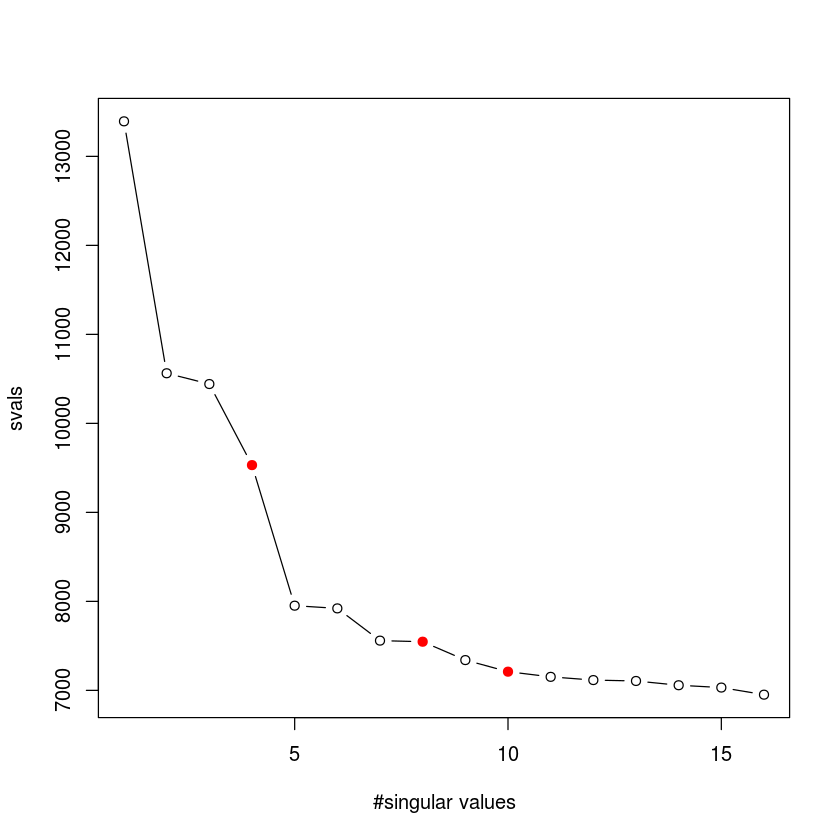

In [2]:
getElbows <- function(d, n = 3, threshold = FALSE)
{
  if (is.unsorted(-d))
    stop("d must be sorted decreasingly!")

  if (!is.logical(threshold))
    d <- d[d > threshold]

  p <- length(d)
  if (p == 0)
    stop(paste("d must have elements that are larger than the threshold ",
               threshold), "!", sep="")

  lq <- rep(0.0, p)                     # log likelihood, function of q
  for (q in 1:p) {
    mu1 <- mean(d[1:q])
    mu2 <- mean(d[-(1:q)])              # = NaN when q = p
    sigma2 <- (sum((d[1:q] - mu1)^2) + sum((d[-(1:q)] - mu2)^2)) /
      (p - 1 - (q < p))
    lq[q] <- sum( dnorm(  d[1:q ], mu1, sqrt(sigma2), log=TRUE) ) +
      sum( dnorm(d[-(1:q)], mu2, sqrt(sigma2), log=TRUE) )
  }

  q <- which.max(lq)
  if (n > 1 && q < p) {
    return(c(q, q + getElbows(d[(q+1):p], n-1)))
  } else {
    return(q)
  }
}

cols <- rep("black", length(svals))
cols[getElbows(sqrt(svals))] <- "red"
pch <- rep(1, length(svals))
pch[getElbows(sqrt(svals))] <- 19
plot(svals, type="b", xlab="#singular values", col=cols, pch=pch)

In [7]:
gc()

rescale <- function(x) {
if (fm.is.vector(x))
x <- fm.as.matrix(x)
scal <- sqrt(colSums(x * x))
x <- fm.mapply.row(x, scal, fm.bo.div)
}

right <- fm.get.dense.matrix("pg-tmp2-lcc.mat")
right <- right[,1:4]
right <- fm.conv.store(right, in.mem=TRUE)
left <- spm %*% right + fm.mapply.col(fm.as.matrix(right), deg, "*")
left <- fm.conv.store(rescale(left), in.mem = FALSE, name="pg-tmp2-lcc1-left.mat")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1442905,77.1,2164898,115.7,2164898,115.7
Vcells,1442599,11.1,2382689,18.2,1899606,14.5


In [8]:
right <- fm.get.dense.matrix("pg-tmp2-lcc.mat")
right <- right[,1:4]
left <- fm.get.dense.matrix("pg-tmp2-lcc1-left.mat")

In [18]:
vecs <- cbind(left, right)
data <- fm.mapply.row(vecs, sqrt(c(svals[1:4], svals[1:4])), "*")
r <- sqrt(fm.agg.mat(data * data, 1, "+"))
data1 <- data[r > 1/sqrt(svals[1]), ]
dim(data1)
1/sqrt(svals[1])

[1] 60840     8

[1] 0.008640657

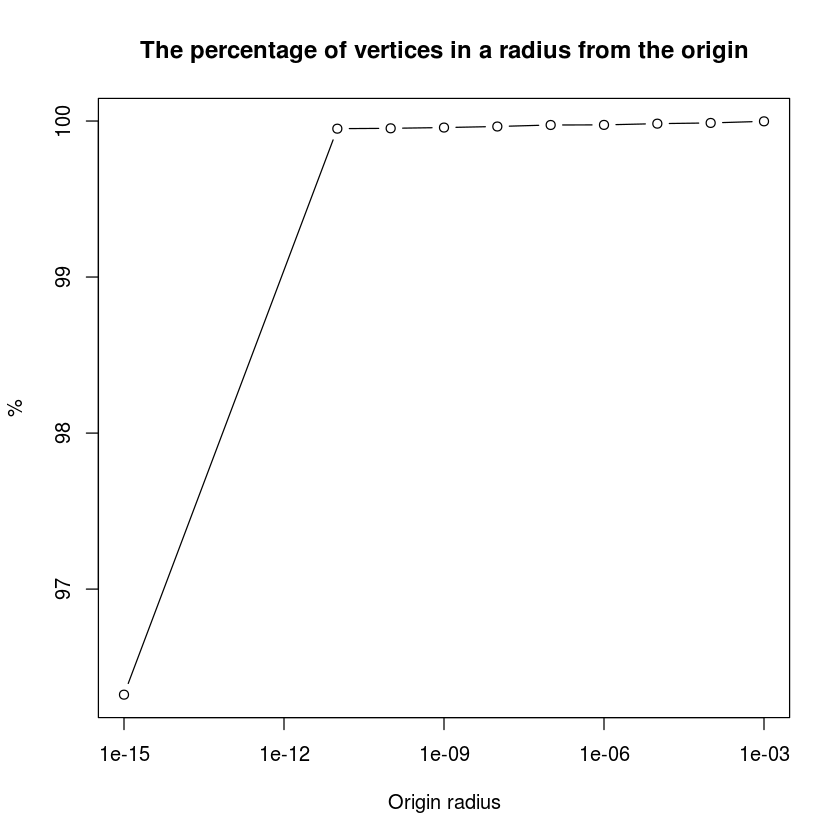

In [21]:
res <- list()
origin.radius <- c(1e-15, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3)
for (val in origin.radius) {
    res <- c(res, r < val)
}
res <- fm.cbind.list(res)
origin.ratio <- as.vector(colSums(as.double(res)))/nrow(res)
plot(x=origin.radius, y=origin.ratio * 100, type="b", xlab="Origin radius", ylab="%",
     main="The percentage of vertices in a radius from the origin", log="x")

In [13]:
vecs

[1] 13393.883 10563.000 10442.000  9531.000  7951.419  7920.965  7558.659
 [8]  7546.493  7340.082  7209.817  7151.679  7115.436  7105.311  7057.379
[15]  7031.373  6951.452